# Fairy circle formation by H<sub>2</sub>S inhibition

# Plant-sulfide model with Turing patterns

The model describes the dynamics of a plant $P$ and sulfide $S$, using the following differential equations:

$$
\begin{aligned}
\frac{\partial P}{\partial t}&= \frac{r}{S} \frac{P^2}{k_p^2 + P^2} - c PS + D_{p} \Delta P\\
\frac{\partial S}{\partial t}&= I_{\rm in}+\varepsilon P^2 - dS + D_{s} \Delta S
\end{aligned}
$$
In terms of equations the crucial conditions for pattern formation is that the scale-dependent feedbacks. 
It reproduces the classical Turing-like fairy circles patterns was shown in Fig.S5(b). 
Here growth of plants in model III is a Hill function with exponential coefficient of 2.0. 
The sulfide concentrations have inhibited the growth of seedling and enhance mortality rate of plants. 
$r$ is the plant maximal growth rate and $k_p$ is the half-saturation constant to control the positive facilitation on plants growth. 
Parameter $\varepsilon$ is the sulfide production for every unit of plant growth, and d describes the detoxification coefficient. 
$I_{\rm in}$ describes the production rate of sulfide concentration arising from bare mudflat.

In [1]:
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import rcParams
from scipy import io
import os

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi']  = 300
rcParams['font.size']   = 16
rcParams['font.family'] = 'StixGeneral'
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

### Parameter definition 

In [2]:
# # parameters
Dp  = 0.05
Ds  = Dp*200.0
kp  = 2.0
r   = 0.8
c   = 10.5
Iin = 0.05
eps = 0.01
d   = 0.5

### Simulation settings

In [3]:
length    = 100.0      # Length of the physical landscape
n         = 512       # Size of the 2D grid
endtime   = 500.0     # end time
dT        = 0.0005    # calculate time step
nplot     = 200
plottime  = endtime/nplot
nsteps    = np.ceil(plottime/dT).astype(int)    #number of time steps

### Precalculations

In [4]:
dX = length/n      # Spatial step size
dY = length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



### Defining the device that is used

In [5]:
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon HD - FirePro D500 Compute Engine



### Initial values

In [6]:
#data = io.loadmat('Initial.mat')
# The array is allocated on the GPU and the initial values are copied onto it
S_host   = (0.01*(np.random.rand(n*n))).astype(np.float32)
S_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)
# generate several seedlings 
im = np.zeros((n, n))
#ix,iy=np.random.randint(0,n,10),np.random.randint(0,n,10)
#im[ix,iy]=1.0
#P_host=(im.reshape(n*n)).astype(np.float32)
P_host   = (0.07*np.random.rand(n*n)).astype(np.float32)
P_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)

### Loading the spatial functions from the ipython file

In [7]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

### Transcribing the 

In [8]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="Dp,Ds,r,kp,c,Iin,eps,d,dX,dY,dT,Grid_Width,Grid_Height"
PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Defining the OpenCL simulation kernel

In [9]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* P, __global float* S)
{

    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {
             float temp = kp*kp+P[current]*P[current];
             float dPdt = r*P[current]*P[current]/(temp*S[current]) - c*P[current]*S[current] + Dp*d2_dxy2(P);
             float dSdt = Iin + eps*P[current]*P[current] - d*S[current] + Ds*d2_dxy2(S);
             
             P[current] = P[current] + dPdt*dT;
             S[current] = S[current] + dSdt*dT;
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(P);
             PeriodicBoundaries(S);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [10]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

In [11]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

Ps=np.zeros((Grid_Width, Grid_Height, nplot))
Ss=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = P_host.shape
# Start the timer:
start_time = time.time()
# Starting the loop
for ii in range(1,nplot):
    # The simulation
    for jj in range(1,nsteps):      
        program.SimulationKernel(queue, global_size, None, P_g, S_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, P_host, P_g)
    cl.enqueue_copy(queue, S_host, S_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ps[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height)
    Ss[:,:,ii] = S_host.reshape(Grid_Width, Grid_Height)
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0, max=200.0)

 Simulation took      : 202.6 (s)


In [12]:
io.savemat('plant.mat', {'P': Ps, 'S': Ss})
#data = io.loadmat(matfn)

### Plotting the results

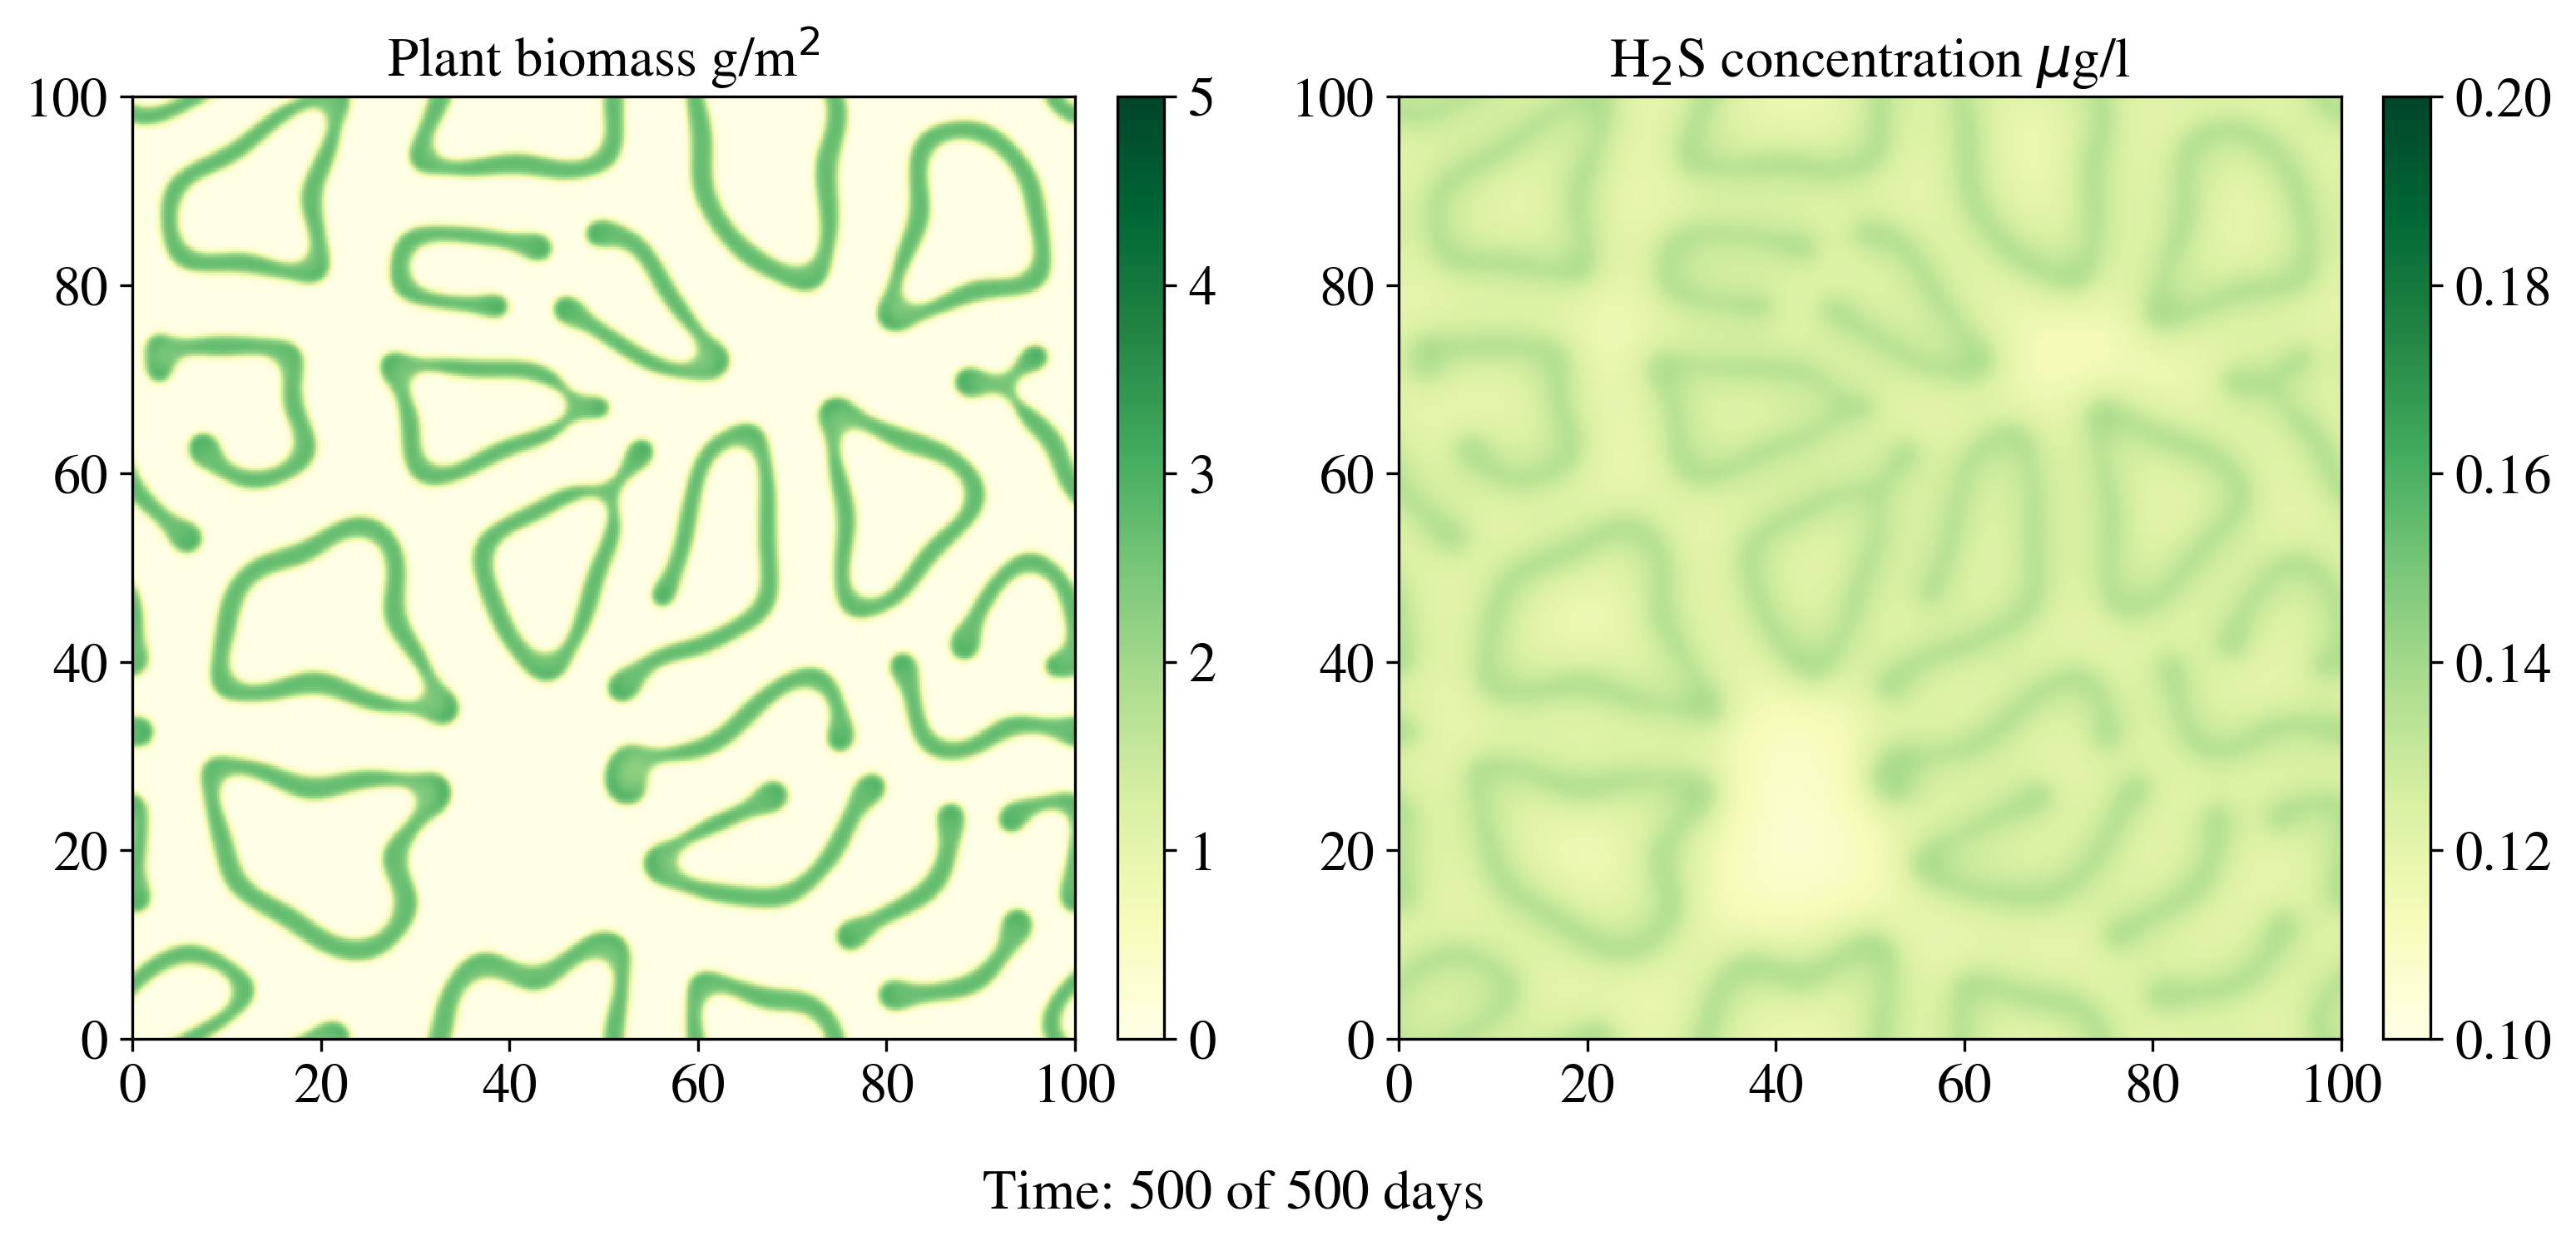

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im0 = ax[0].imshow(P_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length], clim=(0,5));
plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);ax[0].set_title('Plant biomass g/m$^2$');

im1 = ax[1].imshow(S_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length], clim=(0.1,0.2));
plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);ax[1].set_title('H$_2$S concentration $\mu$g/l');

text=fig.suptitle("Time: %1.0f of %1.0f days" % (endtime, endtime), x=0.5, y=0.02, fontsize=16);

### Making a movie

In [14]:
from matplotlib import animation, rc
import os
if not os.path.exists("oldSim"):
    os.makedirs("oldSim")
    
print("Progress :");
PB2 = FloatProgress(min=0, max=nplot); display(PB2)
def updatefig(i): # To update the image at each iteration
    global Ps, Ss
    im0.set_array(Ps[:,:,i])
    im1.set_array(Ss[:,:,i])
    text.set_text("Time: %1.0f of %1.0f days" % ((i+1)/nplot*endtime, endtime));
    fig.savefig('oldSim/Sulfide'+str(i)+'.pdf',bbox_inches='tight')
    PB2.value += 1
    return im0,im1,
#for ii in range(1,nplot):
#    updatefig(ii)
    
ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)
print("Save figure finshes!")

Progress :


FloatProgress(value=0.0, max=200.0)

Save figure finshes!


In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video())

Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=1800)
ani.save('Sulfide_Turing.mp4', writer=writer)
print("Save movies finshes!")

The End, Kang